In [1]:
import sys, os

In [2]:
sys.path.extend([os.path.abspath('../../../../')])

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Recovering the result of Reinhold and Pierrehumbert (1982)

In this example, we will recover the attractor shown in

* Reinhold, B. B., & Pierrehumbert, R. T. (1982). *Dynamics of weather regimes: Quasi-stationary waves and blocking*. Monthly Weather Review, **110** (9), 1105-1145. [doi:10.1175/1520-0493(1982)110%3C1105:DOWRQS%3E2.0.CO;2](https://doi.org/10.1175/1520-0493(1982)110%3C1105:DOWRQS%3E2.0.CO;2)

obtained with a 2-layer channel QG atmosphere truncated at wavenumber 2 on a beta-plane and a simple orography (a mountain and a valley). 

## Modules import

Loading of some modules...

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Initializing the random number generator (for reproducibility). -- Disable if needed.

In [5]:
np.random.seed(210217)

Importing the model's modules

In [6]:
from qgs.params.params import QgParams
from qgs.integrators.integrator import RungeKuttaIntegrator, RungeKuttaTglsIntegrator
from qgs.functions.tendencies import create_tendencies
from qgs.plotting.util import std_plot

and diagnostics

In [7]:
from qgs.diagnostics.streamfunctions import MiddleAtmosphericStreamfunctionDiagnostic
from qgs.diagnostics.variables import VariablesDiagnostic
from qgs.diagnostics.multi import MultiDiagnostic

## Systems definition

General parameters

In [8]:
# Time parameters
dt = 0.1
# Saving the model state n steps
write_steps = 5

number_of_trajectories = 1
number_of_perturbed_trajectories = 10

Setting some model parameters

In [9]:
# Model parameters instantiation with some non-default specs
model_parameters = QgParams({'phi0_npi': np.deg2rad(50.)/np.pi, 'hd':0.045})
# Mode truncation at the wavenumber 2 in both x and y spatial coordinate
model_parameters.set_atmospheric_channel_fourier_modes(2, 2)

# Setting the orography depth and the meridional temperature gradient
model_parameters.ground_params.set_orography(0.2, 1)
model_parameters.atemperature_params.set_thetas(0.1, 0)

In [10]:
# Printing the model's parameters
model_parameters.print_params()

Qgs parameters summary

General Parameters:
'time_unit': days,
'rr': 287.058  [J][kg^-1][K^-1]  (gas constant of dry air),
'sb': 5.67e-08  [J][m^-2][s^-1][K^-4]  (Stefan-Boltzmann constant),

Scale Parameters:
'scale': 5000000.0  [m]  (characteristic space scale (L*pi)),
'f0': 0.0001032  [s^-1]  (Coriolis parameter at the middle of the domain),
'n': 1.3    (aspect ratio (n = 2 L_y / L_x)),
'rra': 6370000.0  [m]  (earth radius),
'phi0_npi': 0.2777777777777778    (latitude expressed in fraction of pi),
'deltap': 50000.0  [Pa]  (pressure difference between the two atmospheric layers),

Atmospheric Parameters:
'kd': 0.1  [nondim]  (atmosphere bottom friction coefficient),
'kdp': 0.01  [nondim]  (atmosphere internal friction coefficient),
'sigma': 0.2  [nondim]  (static stability of the atmosphere),

Atmospheric Temperature Parameters:
'hd': 0.045  [nondim]  (Newtonian cooling coefficient),
'thetas[1]': 0.1    (spectral components 1 of the temperature profile),
'thetas[2]': 0.0    (spectral

Creating the tendencies function

In [11]:
f, Df = create_tendencies(model_parameters)

## Time integration and plotting a section of the attractor

Defining an integrator

In [12]:
integrator = RungeKuttaIntegrator()
integrator.set_func(f)

Start on a random initial condition and integrate over a transient time to obtain an initial condition on the attractors

In [13]:
ic = np.random.rand(model_parameters.ndim)*0.1
integrator.integrate(0., 200000., dt, ic=ic, write_steps=0)
time, ic = integrator.get_trajectories()

Now integrate to obtain a trajectory on the attractor

In [14]:
integrator.integrate(0., 100000., dt, ic=ic, write_steps=write_steps)
time, traj = integrator.get_trajectories()

and plot $\psi_2^{\rm a}$ as a function of $\psi_3^{\rm a}$

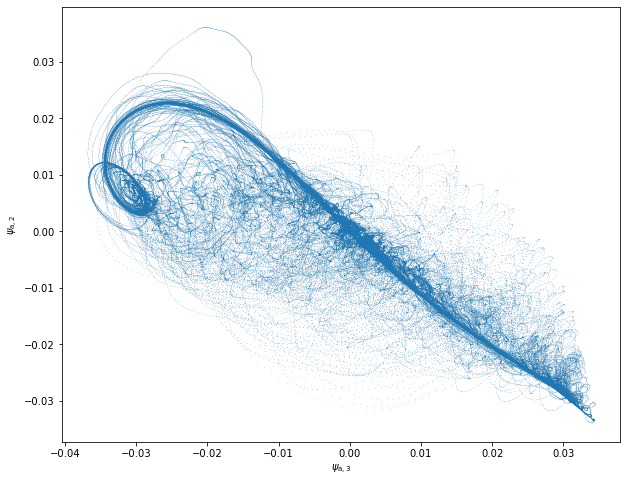

In [15]:
varx = 2
vary = 1
plt.figure(figsize=(10, 8))

plt.plot(traj[varx], traj[vary], marker='o', ms=0.07, ls='')

plt.xlabel('$'+model_parameters.latex_var_string[varx]+'$')
plt.ylabel('$'+model_parameters.latex_var_string[vary]+'$');

to recover the figure 3 of the Reinhold and Pierrehumbert article mentioned above.

## Showing the resulting fields

One can use objects called `Diagnostic` to plot movies of the model fields.
Here we show how to use them and plot the simultaneous time evolution of the variables $\psi_2$ and $\psi_3$, and the geopotential height field at 500 hPa over the orographic height.

Creating the diagnostics:

* For the 500hPa geopotential height:

In [16]:
psi = MiddleAtmosphericStreamfunctionDiagnostic(model_parameters, geopotential=True)

* For the nondimensional variables $\psi_2$ and $\psi_3$:

In [17]:
variable_nondim = VariablesDiagnostic([2, 1], model_parameters, False)

In [18]:
# setting also the background
background = VariablesDiagnostic([2, 1], model_parameters, False)
background.set_data(time, traj)

Creating a multi diagnostic with both:

In [19]:
m = MultiDiagnostic(1,2)
m.add_diagnostic(variable_nondim, diagnostic_kwargs={'show_time': False, 'background': background}, plot_kwargs={'ms': 0.2})
m.add_diagnostic(psi, diagnostic_kwargs={'style': 'contour', 'contour_labels': False}, plot_kwargs={'colors': 'k'})
m.set_data(time[:501], traj[:501])

and create the movie:

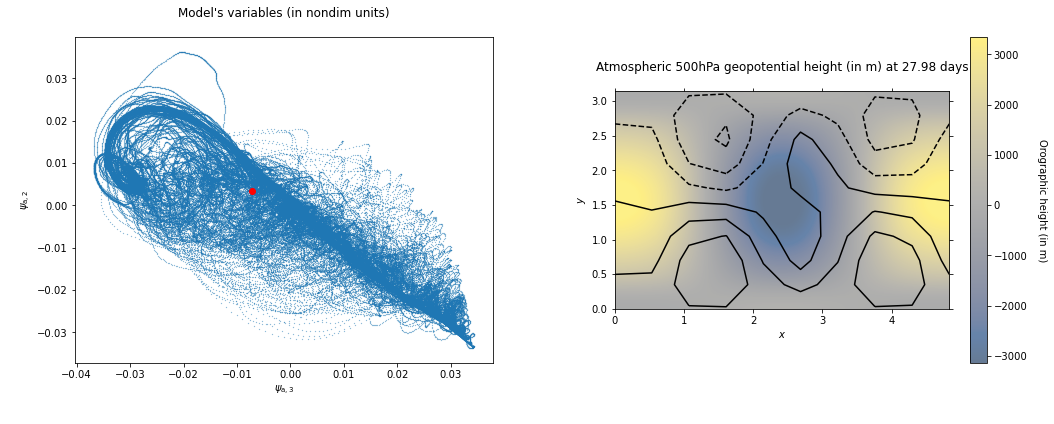

In [20]:
m.movie(figsize=(15,6), anim_kwargs={'interval': 100, 'frames': 500})